## Generalized point transformations of Gaussians
#### arXiv: 2411.04759
In this notebook, we will show how to use the functions in this repository. 

First, we have to get maps which we want to fit these models to. We need a map (e.g., convergence, matter density contrast) and a pixelized and low-passed filtered version of it.

This functions have been tested with maps at $N_{\mathrm{side}} = 256$. Be warned that, if you have a map at a higher resolution, just downgrading by taking averages over the children pixels introduces a pixel window function. In order to avoid this issue, we recommend computing the alms of the high resolution map up to $\ell_{\mathrm{max}} = 3N_{\mathrm{side}} - 1$, where $N_{\mathrm{side}}$ is the low-resolution $N_{\mathrm{side}}$, and transform back to get a map at the resolution $N_{\mathrm{side}}$.

On the other hand, to get a low-passed and pixelized map, it is as easy as downgrading by taking averages over the children pixels, and then apply a low-pass filter (i.e., $a_{\ell m} = 0$ for $\ell>2N_{\mathrm{side}}$) 

We also need a pixel window function $W_\ell$ defined as:
$$a_{\ell m}^{\mathrm{pix}} = a_{\ell m}W_\ell$$
In this notebook we need $W_\ell$ at each $\ell$ up to $\ell{\mathrm{max}} = 3N_{\mathrm{side}}-1$.

Finally, we have to specify the $G_N^{-1}$ model that we want to fit.

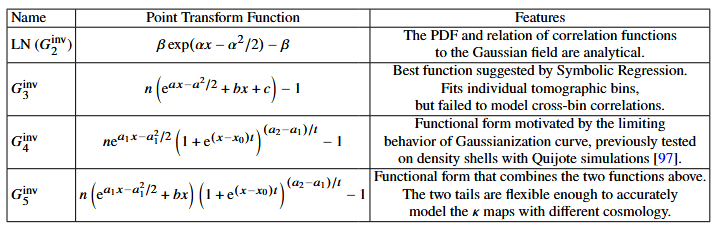

In [ ]:
import numpy as np 
import healpy as hp 

# Specify the follwing:
# ================================================
# The shape of the maps is (N_bins,N_pix)
# The shape of cls is (N_bins,N_bins,gen_lmax + 1)
# The shape of pixwin is (gen_lmax + 1)
# ================================================
path2map      = 'data/Kappa_Gower_St_ID_44_DESy3_tomography_Nside_256.npy'
path2lpmap    = 'data/Kappa_Gower_St_ID_44_DESy3_tomography_Nside_256_lowpassed_pix.npy'
path2pixwin   = 'data/pixwin_256.npy'
path2cls      = 'data/Cls_NG_Gower_St_ID_44.npy'
N             = '3'
# ================================================
kappa_map     = np.load(path2map)
kappa_map_lp  = np.load(path2lpmap)
cl_NG         = np.load(path2cls)
N_bins        = kappa_map.shape[0]
N_pix         = kappa_map.shape[1]
Nside         = hp.npix2nside(N_pix)         
gen_lmax      = 3*Nside-1   
lmax          = 2*Nside

### One small detail:
Each $G_N^{-1}$ transformation appears to have $N$ degrees of freedom. However, information about the variance of the fields is encoded in the power spectrum $\mathrm{Var}(\mathrm{Field}|C_{\ell})$. So, if we have $\mathrm{Var}(\mathrm{Field}|\mathrm{Parameters})$, then the relation

$$\mathrm{Var}(\mathrm{Field}|\mathrm{Parameters}) = \mathrm{Var}(\mathrm{Field}|C_{\ell})$$

gives an additional constraint. Hence, in reality we only have $N-1$ degrees of freedom.

Only $G_2$ and $G_3$ have proper has fitter that fits $N-1$ degrees of freedom, as only those have analytical expressions of $\mathrm{Var}(\mathrm{Field}|\mathrm{Parameters})$. So, modify this notebook accordingly if you use a different $G_N$ transformation.

In [ ]:
from fitter.auxiliary_functions import histogramer2d
from fitter.fitter import fit_gn,fit_gn_with_constraint

fitted_params       = np.zeros((N_bins,int(N))) # Fits N-degrees of freedom
fitted_params_w_cls = np.zeros((N_bins,int(N))) # Fits (N-1)-degrees of freedom
for i in range(N_bins):
    _,x,y                  = histogramer2d(kappa_map[i],1000,(-10,4.5))
    fitted_params[i]       = fit_gn(x, y, N)  
    fitted_params_w_cls[i] = fit_gn_with_constraint(x,y,N,cl_NG[i,i])

Once we already have fits of the parameters of a $G_N^{-1}$ model, we can Gaussianize our power spectrum. 

In [ ]:
from fitter.transform_cls import C_NG_to_C_G,diagnose_cl_G

cl_G = C_NG_to_C_G(cl_NG, fitted_params_w_cls, N_bins, N)
# But, we also have to check if the covariance matrix at a given ell mode is 
# positive-definite
diagnose_cl_G(cl_G)

With a set of parameters and a Gaussianized power spectrum, now we are in the position to generate mocks.

In [ ]:
# We want to get the pixel window function to generate mocks
# that are pixelized and low-passed 

ell_pixwin, _     = hp.Alm.getlm(lmax)
pixwin            = np.load(path2pixwin)
pixwin_ell_filter = pixwin[ell_pixwin]


Next, we want to check if our mocks have the right power spectrum and the right probability density function. To do so, we compute a mock that is low-passed filtered and pixelized and one that is not. 

Additionally, we compute the quantity
$$\left\langle\frac{C_\ell^{\mathrm{mock}}}{W_\ell^2C_\ell}\right\rangle$$
since we want to check if our mocks have the right power spectrum. We will do that using 200 mocks.

In [ ]:
from fitter.debiaser import cl_mock_avg
from fitter.mocker import get_y_maps,get_kappa,get_kappa_pixwin

average_ratio  = cl_mock_avg(cl_NG,cl_G,fitted_params_w_cls,pixwin,pixwin_ell_filter,N,Nside,N_bins,auto=False)
y_maps, _      = get_y_maps(cl_G, Nside, N_bins, gen_lmax)
kappa_mock     = get_kappa(y_maps, N_bins, N, fitted_params_w_cls)  
kappa_mock_pix = get_kappa_pixwin(y_maps,N_bins,N,fitted_params_w_cls,Nside,pixwin_ell_filter)


In [ ]:
from fitter.plots import ratio_ploter,hist_comparisson_plotter,hist_comparisson_plotter_linear

# We check our results by plotting them
ratio_ploter(average_ratio,N_bins)
hist_comparisson_plotter(kappa_map,kappa_map_lp,kappa_mock,kappa_mock_pix,N_bins,N)
hist_comparisson_plotter_linear(kappa_map,kappa_map_lp,kappa_mock,kappa_mock_pix,N_bins,N)

For completeness, we might as well repeat this process with the parameters fitted using $N$ degrees of freedom. Let us see how that compares to our previous plots

In [ ]:
cl_G = C_NG_to_C_G(cl_NG, fitted_params, N_bins, N)
diagnose_cl_G(cl_G)
average_ratio  = cl_mock_avg(cl_NG,cl_G,fitted_params,pixwin,pixwin_ell_filter,N,Nside,N_bins,auto=False)
y_maps, _      = get_y_maps(cl_G, Nside, N_bins, gen_lmax)
kappa_mock     = get_kappa(y_maps, N_bins, N, fitted_params)  
kappa_mock_pix = get_kappa_pixwin(y_maps,N_bins,N,fitted_params,Nside,pixwin_ell_filter)
ratio_ploter(average_ratio,N_bins)
hist_comparisson_plotter(kappa_map,kappa_map_lp,kappa_mock,kappa_mock_pix,N_bins,N)
hist_comparisson_plotter_linear(kappa_map,kappa_map_lp,kappa_mock,kappa_mock_pix,N_bins,N)
